# Rule based

In [6]:
import pandas as pd
import numpy as np
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import re


In [2]:
books = pd.read_csv("data/books.csv")
train = pd.read_csv("data/train_ratings.csv")
test = pd.read_csv("data/test_ratings.csv")
users = pd.read_csv("data/users.csv")
sub = pd.read_csv("data/sample_submission.csv")

In [50]:
train

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9
...,...,...,...
306790,278843,0743525493,7
306791,278851,067161746X,6
306792,278851,0884159221,7
306793,278851,0912333022,7


In [51]:
train_df = train.merge(users, how = 'left', on = 'user_id').merge(books, how ='left', on = 'isbn')

In [52]:
train_df

,user_id,isbn,rating,location,age,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,0002005018,4,"timmins, ontario, canada",NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,67544,0002005018,7,"toronto, ontario, canada",30.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,0002005018,8,"kingston, ontario, canada",NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,0002005018,8,"comber, ontario, canada",NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,0002005018,9,"guelph, ontario, canada",NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,"pismo beach, california, usa",28.0,The Motley Fool's What To Do with Your Money N...,David Gardner,2002.0,Simon & Schuster Audio,http://images.amazon.com/images/P/0743525493.0...,NaN,NaN,NaN,images/0743525493.01.THUMBZZZ.jpg
306791,278851,067161746X,6,"dallas, texas, usa",33.0,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,['Humor'],A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg
306792,278851,0884159221,7,"dallas, texas, usa",33.0,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg
306793,278851,0912333022,7,"dallas, texas, usa",33.0,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,['Fiction'],These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg


In [53]:
train['isbn'].nunique()

129777

In [54]:
isbn = train_df.groupby(['isbn'])['rating'].mean().to_frame()

In [55]:
isbn_mean = train.merge(isbn, how = 'left', on='isbn')

In [56]:
isbn_mean

,user_id,isbn,rating_x,rating_y
0,8,0002005018,4,6.857143
1,67544,0002005018,7,6.857143
2,123629,0002005018,8,6.857143
3,200273,0002005018,8,6.857143
4,210926,0002005018,9,6.857143
...,...,...,...,...
306790,278843,0743525493,7,7.000000
306791,278851,067161746X,6,6.000000
306792,278851,0884159221,7,7.000000
306793,278851,0912333022,7,7.000000


# 아이템별 평균 - 자신의 평균

In [75]:
isbn_mean['sub'] = isbn_mean['rating_x'] - isbn_mean['rating_y']
isbn_mean

,user_id,isbn,rating_x,rating_y,sub
0,8,0002005018,4,6.857143,-2.857143
1,67544,0002005018,7,6.857143,0.142857
2,123629,0002005018,8,6.857143,1.142857
3,200273,0002005018,8,6.857143,1.142857
4,210926,0002005018,9,6.857143,2.142857
...,...,...,...,...,...
306790,278843,0743525493,7,7.000000,0.000000
306791,278851,067161746X,6,6.000000,0.000000
306792,278851,0884159221,7,7.000000,0.000000
306793,278851,0912333022,7,7.000000,0.000000


In [76]:
isbn_mean.describe()

,user_id,rating_x,rating_y,sub
count,306795.000000,306795.000000,306795.000000,3.067950e+05
mean,136128.416099,7.069714,7.069714,4.467020e-18
std,80512.194379,2.433217,1.726891,1.714173e+00
min,8.000000,1.000000,1.000000,-7.806061e+00
25%,67591.000000,6.000000,6.472727,-3.684211e-01
50%,134076.000000,8.000000,7.300000,0.000000e+00
75%,206438.000000,9.000000,8.000000,9.130435e-01
max,278854.000000,10.000000,10.000000,6.845161e+00


In [77]:
isbn_mean['sub'].mean()

4.4670196763222775e-18

In [78]:
isbn_mean['sub'].std()

1.7141732213996124

## 아이템 별 평균 - 자신의 평균의 표준편차의 표준편차

In [79]:
std_count = isbn_mean.groupby(['isbn'])['sub'].std().value_counts().sort_index()

In [97]:
std_count=std_count.to_frame()

In [89]:
std_count.to_csv("std_count.csv")

array([[<AxesSubplot: title={'center': 'sub'}>]], dtype=object)

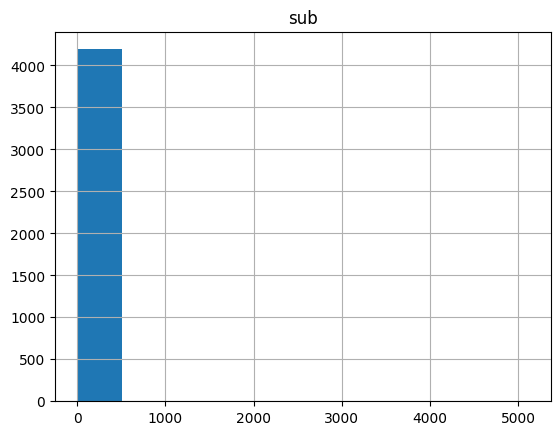

In [98]:
std_count.hist()

## 총 평균, 아이템별 평균의 평균

In [105]:
train['rating'].mean()

7.069714304340032

In [104]:
train.groupby(['isbn'])['rating'].mean().mean()

6.932617576087269

## 못봤던 사람 -> 7  / 봤던사람 -> 그사람의 평균

In [35]:
train = pd.read_csv("data/train_ratings.csv")
count=train.groupby("user_id").size()
dfcount = pd.DataFrame(count, columns=["count"])
test=pd.merge(test,dfcount, how='left', on='user_id')

test['count'] = test['count'].fillna(0)
test.set_index("user_id",inplace = True)

for row in test.itertuples():
    if row[3] == 0 :
        test.at[row[0],"rating"] = 7
    else:
        test.at[row[0],"rating"] = train[train['user_id']== row[0]]['rating'].mean()

test = test.reset_index()
test = test.drop(['count'], axis=1)



In [36]:
test

,user_id,isbn,rating
0,11676,0002005018,6.779891
1,116866,0002005018,7.734694
2,152827,0060973129,8.400000
3,157969,0374157065,8.000000
4,67958,0399135782,8.090909
...,...,...,...
76694,278543,1576734218,6.666667
76695,278563,3492223710,7.000000
76696,278633,1896095186,7.032258
76697,278668,8408044079,3.000000


# 장르별 평균

In [4]:
books['category'].nunique()

4292

In [7]:
# books 카테고리 전처리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']  
books['category_high'] = books['category'].copy()
books.loc[books[books['category']=='biography'].index, 'category_high'] = 'biography autobiography'
books.loc[books[books['category']=='autobiography'].index,'category_high'] = 'biography autobiography'
books.loc[books[books['category'].str.contains('history',na=False)].index,'category_high'] = 'history'
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
# 5개 이하인 항목은 others로 묶어주도록 하겠습니다.
others_list = category_high_df[category_high_df['count']<5]['category'].values
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'
del books['category']
books.rename(columns = {'category_high':'category'},inplace=True)


In [8]:
books['category'].nunique()

489

In [42]:
train_df = train.merge(users, how = 'left', on = 'user_id').merge(books, how ='left', on = 'isbn')

In [43]:
train_df.groupby(['category'])['rating'].mean().sort_values()

category
Monsters                    2.555556
Bicycle touring             2.750000
Sociology                   3.750000
Children s songs            4.125000
Questions and answers       4.250000
                              ...   
Bibles                      8.935484
African American authors    8.947368
Medicine Popular            9.166667
SAT Educational test        9.250000
Beaches                     9.500000
Name: rating, Length: 489, dtype: float64

In [44]:
category_mean = train_df.groupby(['category'])['rating'].mean().sort_values().to_frame()
category_mean = category_mean.reset_index()
category_mean

,category,rating
0,Monsters,2.555556
1,Bicycle touring,2.750000
2,Sociology,3.750000
3,Children s songs,4.125000
4,Questions and answers,4.250000
...,...,...
484,Bibles,8.935484
485,African American authors,8.947368
486,Medicine Popular,9.166667
487,SAT Educational test,9.250000


In [45]:
from collections import defaultdict
rating_dict = defaultdict(list)
for index, row in category_mean.iterrows():
    if row[1] <= 2:
        rating_dict[1].append(row[0])
    elif row[1] <=4:
        rating_dict[2].append(row[0])
    elif row[1] <=6:
        rating_dict[3].append(row[0])
    elif row[1] <=8:
        rating_dict[4].append(row[0])
    elif row[1] <=10:
        rating_dict[5].append(row[0])


In [46]:
for key, value in rating_dict.items():
    print(f"{key} group", value)

2 group ['Monsters', 'Bicycle touring', 'Sociology']
3 group ['Children s songs', 'Questions and answers', 'Cheerleading', 'Antisemitism', 'business', 'City planning', 'Cooking American', 'Computer graphics', 'Handicraft', 'Mothers and daughters', 'Bible stories', 'Communication in marriage', 'Farm life', 'High schools', 'Sisters', 'Hollywood Los Angeles Calif', 'Behavior', 'Baseball stories', 'Internet', 'Clowns', 'Halloween', 'Grandmothers', 'Cruise ships', 'Vietnam War 1961 1975', 'family', 'College students', 'Divorce', 'Ants', 'Attitude Psychology', 'Babysitters', 'Caribbean Area', 'Communication', 'Acting', 'Clubs', 'Women', 'Motion picture actors and actresses', 'Aromatherapy', 'Family life', 'Self actualization Psychology', 'Authors French', 'Germany', 'Plot your own stories', 'Achievement motivation', 'Chemistry', 'Feng shui', 'Berlin Germany', 'Aeronautics', 'Vampires', 'Success', 'Horror', 'Readers', 'Amnesia', 'Fear', 'Ecology', 'Cosmology', 'Dreams', 'Homeless persons', 'S

In [63]:
train_category_count_mean_std = train_df.groupby(['category'])['rating'].agg(['mean', 'count','std']).sort_values(by='mean').reset_index()
train_category_count_mean_std

,category,mean,count,std
0,Monsters,2.555556,9,1.013794
1,Bicycle touring,2.750000,4,0.500000
2,Sociology,3.750000,4,3.095696
3,Children s songs,4.125000,8,3.226564
4,Questions and answers,4.250000,4,2.629956
...,...,...,...,...
484,Bibles,8.935484,31,1.504116
485,African American authors,8.947368,19,1.025978
486,Medicine Popular,9.166667,6,1.329160
487,SAT Educational test,9.250000,4,1.500000


In [39]:
test_df = test.merge(users, how = 'left', on = 'user_id').merge(books, how ='left', on = 'isbn')

In [41]:
test_category_count= test_df.groupby(['category'])['rating'].count().sort_values().to_frame().reset_index()
test_category_count

,category,rating
0,Antiques,1
1,Applications for positions,1
2,Comedians,1
3,Ants,1
4,Antisemitism,1
...,...,...
454,fiction,905
455,others,1751
456,Biography Autobiography,1899
457,Juvenile Fiction,3022


## train 카테고리와 test 카테고리가 얼마나 겹치는지

In [64]:
train_set = set(train_category_count_mean_std['category'])
len(train_set)

489

In [54]:
test_set = set(test_category_count['category'])
len(test_set)

459

## train, test 카테고리 유형 비교
- test에 있는 카테고리 train에 다 있음
- 전처리 적용한 카테고리임

In [58]:
print("train에만 있는 category", len(train_set - test_set))
print("test에만 있는 category", len(test_set - train_set))
print("둘다있는 category", len(train_set&test_set))

train에만 있는 category 30
test에만 있는 category 0
둘다있는 category 459


In [68]:
print(train_category_count_mean_std[train_category_count_mean_std['category'] == 'Fiction'])
print(train_category_count_mean_std[train_category_count_mean_std['category'] == 'FICTION'])
print(train_category_count_mean_std[train_category_count_mean_std['category'] == 'fiction'])

    category      mean   count       std
202  Fiction  6.978585  108569  2.413085
    category      mean  count       std
291  FICTION  7.270396    429  2.402605
    category      mean  count      std
286  fiction  7.249581   3582  2.45216


In [70]:
train_category_count_mean_std.describe()

,mean,count,std
count,489.000000,489.000000,489.000000
mean,7.013937,379.496933,2.354115
std,0.918512,4964.977292,0.620319
min,2.555556,2.000000,0.500000
25%,6.526316,8.000000,2.070197
50%,7.146341,15.000000,2.404361
75%,7.555556,43.000000,2.675978
max,9.500000,108569.000000,6.363961


## isbn 별로 mean, count ,std 계산

In [72]:
train_isbn_count_mean_std = train_df.groupby(['isbn'])['rating'].agg(['mean', 'count','std']).sort_values(by='mean').reset_index()
train_isbn_count_mean_std

,isbn,mean,count,std
0,0231105592,1.0,1,NaN
1,1558176594,1.0,1,NaN
2,0312922620,1.0,1,NaN
3,0812885074,1.0,1,NaN
4,8466302948,1.0,1,NaN
...,...,...,...,...
129772,0528913662,10.0,1,NaN
129773,1928556396,10.0,2,0.0
129774,0345439198,10.0,1,NaN
129775,0345438736,10.0,1,NaN


In [73]:
train_isbn_count_mean_std.describe()


,mean,count,std
count,129777.000000,129777.000000,41385.000000
mean,6.932618,2.364017,1.903035
std,2.286600,6.410544,1.292632
min,1.000000,1.000000,0.000000
25%,6.000000,1.000000,0.707107
50%,7.333333,1.000000,1.652504
75%,8.500000,2.000000,2.792848
max,10.000000,566.000000,6.363961


In [ ]:
# submission = pd.read_csv(‘./data/sample_submission.csv’)
submission = pd.read_csv(‘./submit/FM_dim2_local_2.4013.csv’)
train = pd.read_csv(‘./data/train_ratings.csv’)
count=train.groupby(“isbn”).size()
dfcount = pd.DataFrame(count, columns=[“count”])
train=pd.merge(train,dfcount, how=‘left’, on=‘isbn’)
submission=pd.merge(submission,dfcount, how=‘left’, on=‘isbn’)
submission[‘count’] = submission[‘count’].fillna(0)
submission.set_index(“isbn”,inplace = True)
isbnlist = []
for row in submission.itertuples():
    if row[0] not in isbnlist:
        if row[3] == 0 :                                                       # 한명
            submission.at[row[0],“rating”] = 6.884027966331795                 # 1개 isbn 평균 (여기서 카테고리까지 생각해서 +- 적용하기)
        else:
            if train[train[‘user_id’]== row[1]][‘count’].mean() >5 :            # 3명 이상이 rating 매긴 user_id
                if train[train[‘user_id’]== row[1]][‘rating’].std() < 0.5:        # 각자 매긴 rating 의 표준편차가 1 이하인 사람에게만 적용
                    submission.at[row[0],“rating”] = train[train[‘isbn’]== row[0]][‘rating’].mean()
        isbnlist.append(row[0])
submission = submission.reset_index()
submission.set_index(“user_id”,inplace = True)
submission = submission.reset_index()
# submission = submission.drop([‘count’], axis=1)

## CSV 저장

In [128]:
submission = pd.read_csv( './data/sample_submission.csv')


# test['rating'].head()
submission=pd.concat([submission.drop(['rating'],axis=1),test['rating']],axis=1)
submission.head(10)

,user_id,isbn,rating
0,11676,0002005018,0.0
1,116866,0002005018,0.0
2,152827,0060973129,0.0
3,157969,0374157065,8.0
4,67958,0399135782,0.0
5,213191,0399135782,0.0
6,245827,0399135782,0.0
7,11676,0671870432,0.0
8,263256,1558746218,7.0
9,226745,1881320189,0.0


In [58]:
num = 1
import time

now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')
submission.to_csv('submit/{}_rule_based_{}.csv'.format(save_time,num), index=False)


# 기존 파일에 적용

In [134]:
# submission = pd.read_csv('./data/sample_submission.csv')
submission = pd.read_csv('./submit/기존파일.csv')
train = pd.read_csv('./data/train_ratings.csv')

count=train.groupby("user_id").size()
dfcount = pd.DataFrame(count, columns=["count"])

train=pd.merge(train,dfcount, how='left', on='user_id')
submission=pd.merge(submission,dfcount, how='left', on='user_id')
submission['count'] = submission['count'].fillna(0)
submission.set_index("user_id",inplace = True)

for row in submission.itertuples():
    if row[3] == 0 :
        submission.at[row[0],"rating"] = 7
    else:
        if train[train['user_id']== row[0]]['count'].mean() >5 :            #5명 이상이 rating 매긴 user_id
            if train[train['user_id']== row[0]]['rating'].std() < 1:        #각자 매긴 rating 의 표준편차가 1 이하인 사람에게만 적용
                submission.at[row[0],"rating"] = train[train['user_id']== row[0]]['rating'].mean()



submission = submission.reset_index()
submission = submission.drop(['count'], axis=1)


In [112]:
train[train['user_id']== 219008]['rating'].std()
# train.head(10)

1.6138820851026834

In [135]:
submission.head(10)

,user_id,isbn,rating
0,11676,0002005018,8.220166
1,116866,0002005018,9.643744
2,152827,0060973129,9.590261
3,157969,0374157065,8.000000
4,67958,0399135782,10.376624
5,213191,0399135782,6.144351
6,245827,0399135782,5.271151
7,11676,0671870432,6.633573
8,263256,1558746218,7.000000
9,226745,1881320189,8.492176


In [147]:
num = 2

now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')
submission.to_csv('submit/{}_rule_based_{}.csv'.format(save_time,num), index=False)